In [1]:
#maps of detections and candidates and True Color for the Western US fires

In [2]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import pandas as pd
import os
import datetime as dt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gs
from skimage import exposure
import matplotlib.dates as mdates

In [3]:
cartopy.config['data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
cartopy.config['pre_existing_data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
cartopy.config['data_dir']

'/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy'

In [4]:
def scale_bar(ax, length=None, location=(0.15, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    credit: https://stackoverflow.com/questions/32333870/how-can-i-show-a-km-ruler-on-a-cartopy-matplotlib-plot
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby+600, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom')

(0.0, 1.0, 0.0, 1.0)

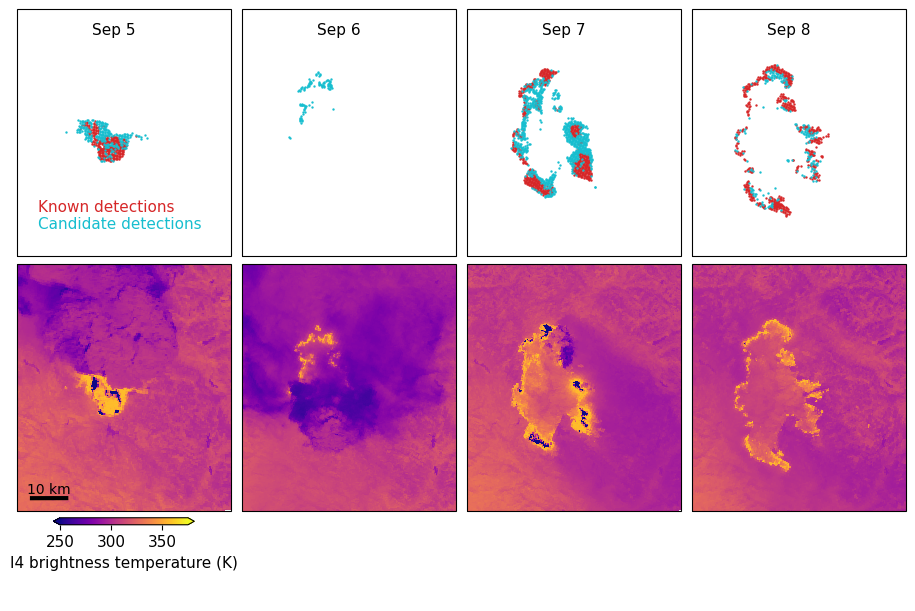

In [5]:
root = '/css/viirs/data/'
extent = [-119.6,-118.9,36.9,37.6] #creek zoomed

fig, axes = plt.subplots(3,4, subplot_kw={'projection': ccrs.Miller()}, gridspec_kw={'height_ratios':[3,3,1]}, constrained_layout=True, figsize=(9,6))
axes = axes.flatten()

#4 dates for creek fire
#Sep 5 249 21:18
#Sep 6 250 21:00
#Sep 7 251 20:42
#Sep 8 252 20:24

timestamps = ['A2020249.2118','A2020250.2100','A2020251.2042','A2020252.2024']

dets = pd.read_csv('/discover/nobackup/scoffie1/WUS_Jun-Nov2020_dets_SNPP_clipped.csv')
dets = dets[dets.Incid_Name=='CREEK']
dets.acq_date = pd.to_datetime(dets.acq_date)

blue = mpl.colormaps['tab10'](9) 
red = mpl.colormaps['tab10'](3) 


#first row: candidate plus known dets
a = 0
for t in timestamps:
    year = t[1:5]
    day = t[5:8]
    time = t[-4:]
    date = dt.datetime.strptime(year+day, '%Y%j')
    date_text = date.strftime('%b %-d') 

    
    subset = dets[(dets.acq_date == date) & (dets.acq_time==int(time))]
    
    known = subset[subset.fire_mask > 6]
    axes[a].scatter(known.longitude, known.latitude, color=red, s=0.5, transform=ccrs.Geodetic())
    
    cands = subset[subset.confidence=='x']
    axes[a].scatter(cands.longitude, cands.latitude, color=blue, s=0.5, transform=ccrs.Geodetic())
    
    axes[a].set_extent(extent)
    axes[a].annotate(date_text, xy=(0.35, 0.9),  size=11, xycoords=axes[a].transAxes)

    a = a+1
    
axes[0].annotate('Candidate detections', xy=(0.1, 0.11),  size=11, xycoords=axes[0].transAxes, color=blue)
axes[0].annotate('Known detections', xy=(0.1, 0.18),  size=11, xycoords=axes[0].transAxes, color=red)


#second row: i4 imagery

for t in timestamps:
    year = t[1:5]
    day = t[5:8]
    time = t[-4:]
    date = dt.datetime.strptime(year+day, '%Y%j')

    #get VNP03IMG geolocation
    matches = os.listdir(root + 'Level1/VNP03IMG.trimmed/{}/{}'.format(year, day))
    matches = [match for match in matches if t in match]
    geo = netCDF4.Dataset(root + 'Level1/VNP03IMG.trimmed/{}/{}/{}'.format(year, day,matches[0]))
    lon = geo.groups['geolocation_data']['longitude'][:]
    lat = geo.groups['geolocation_data']['latitude'][:]

    #get VNP02IMG I4 data
    matches = os.listdir(root + 'Level1/VNP02IMG/{}/{}'.format(year, day))
    matches = [match for match in matches if t in match]
    data = netCDF4.Dataset(root + 'Level1/VNP02IMG/{}/{}/{}'.format(year, day,matches[0]))
    i4 = data.groups['observation_data'].variables['I04']
    scale = i4.scale_factor
    offset = i4.add_offset
    i4 = (i4[:,:] - offset) / scale
    i4 = i4.astype(int)
    i4_bt = data.groups['observation_data'].variables['I04_brightness_temperature_lut'][:]
    i4_bt = i4_bt[i4]
    
    scene = (lon > extent[0]) & (lon < extent[1]) & (lat > extent[2]) & (lat < extent[3])

    indices = np.where(scene)

    x0 = indices[0].min()
    x1 = indices[0].max()+1
    y0 = indices[1].min()
    y1 = indices[1].max()+1

    axes[a].set_extent(extent) #fire
    plot = axes[a].pcolormesh(lon[x0:x1, y0:y1], lat[x0:x1, y0:y1], i4_bt[x0:x1, y0:y1], vmin=250, vmax=375, transform=ccrs.PlateCarree(), cmap='plasma')
                                                                    
    a = a+1
    
cbar = plt.colorbar(plot, orientation='horizontal', shrink=0.65, pad=-1, extend='both', ax=axes[8])
cbar.ax.tick_params(labelsize=11)
cbar.set_label('I4 brightness temperature (K)', size=11)
scale_bar(axes[4], 10)
axes[8].axis('off')
axes[9].axis('off')
axes[10].axis('off')
axes[11].axis('off')
#plt.savefig('/home/scoffie1/figures/creek-figure.png', dpi=150)

In [6]:
#plot each timestamp I4 imagery + candidates map + bar chart for Creek fire (Fig S3)

root = '/css/viirs/data/'

extent = [-119.58,-118.8,36.9,37.7] #creek

dets = pd.read_csv('/discover/nobackup/scoffie1/WUS_Jun-Nov2020_dets_SNPP_clipped.csv')
dets = dets[dets.Incid_Name=='CREEK']

#define colormap for fire mask
newcolors = [mpl.colormaps['tab10'](c) for c in [4,6,5,0,9,2,7,8,1,3]]
#newcolors = [mpl.colormaps['tab10'](c) for c in [9,9,9,9,9,9,9,3,3,3]] #just old vs new dets
newcmp = ListedColormap(newcolors)

#swath names - Suomi-NPP, via ladsweb.modaps.eosdis.nasa.gov
with open('/home/scoffie1/links/creek.txt', 'r') as links:
    files = sorted(links.readlines())

files[:4]

['VNP03IMG.A2020249.1000.002.2021125044725.nc\n',
 'VNP03IMG.A2020249.1942.002.2021125045001.nc\n',
 'VNP03IMG.A2020249.2118.002.2021125045016.nc\n',
 'VNP03IMG.A2020250.0942.002.2021125050924.nc\n']

In [49]:
for file in files:
    timestamp = file.split('.')[1:3]
    print(timestamp)
    year = timestamp[0][1:5]
    day = timestamp[0][5:8]
    time = timestamp[1]
    acq_datetime = dt.datetime.strptime(year+day+time, '%Y%j%H%M')
    date = dt.datetime.strptime(year+day, '%Y%j').strftime('%b %d') 
    acq_date = dt.datetime.strptime(year+day, '%Y%j').strftime('%-m/%-d/%y') #match FIRMS
    
    try:
        #get VNP03 geolocation
        matches = os.listdir(f'{root}/Level1/VNP03IMG.trimmed/{year}/{day}')
        matches = [match for match in matches if match[18:22] == time]
        geo = xr.open_dataset(f'{root}/Level1/VNP03IMG.trimmed/{year}/{day}/{matches[0]}', engine='netcdf4',group = 'geolocation_data')
        
        i, j = np.indices(geo.longitude.shape) #line and sample
        scene = ((geo.longitude > extent[0]) & (geo.longitude < extent[1]) & (geo.latitude > extent[2]) & (geo.latitude < extent[3])).values

        indices = np.where(scene)

        x0 = indices[0].min()
        x1 = indices[0].max()+1
        y0 = indices[1].min()
        y1 = indices[1].max()+1
        
        #get VNP02IMG I4 data
        matches = os.listdir(f'{root}/Level1/VNP02IMG/{year}/{day}')
        matches = [match for match in matches if '.'.join(timestamp) in match]
        data = xr.open_dataset(f'{root}/Level1/VNP02IMG/{year}/{day}/{matches[0]}', engine='netcdf4', group='observation_data')
        #data = data.sel(number_of_lines=slice(x0,x1), number_of_pixels=slice(y0,y1))
        
        i4 = data['I04'] #xarray already encodes the scale factor and offset
        scale = data.I04.encoding['scale_factor']
        offset = data.I04.encoding['add_offset']
        i4 = (i4[:,:] - offset) / scale #return to raw values to use lookup table to temperature
        i4 = i4.astype(int)
        i4_bt = data['I04_brightness_temperature_lut'][:]
        i4_bt = i4_bt[i4]
        
    except:
        print('error with file',file)
        continue
        

    subset = dets[(dets.acq_date==acq_date) & (dets.acq_time==int(time))]

    fig = plt.figure(figsize=(11,4), constrained_layout=True)
    grid = gs.GridSpec(1,3, width_ratios=[1.1,1.1,1])
    ax = plt.subplot(grid[0], projection = ccrs.Miller())
    ax2 = plt.subplot(grid[1], projection = ccrs.Miller())
    ax3 = plt.subplot(grid[2])
  
    ax.set_extent(extent)
    plot = ax.pcolormesh(geo.longitude[x0:x1, y0:y1], geo.latitude[x0:x1, y0:y1], i4_bt[x0:x1, y0:y1], vmin=250, vmax=375, transform=ccrs.PlateCarree(), cmap='plasma')
    #cbar = plt.colorbar(plot, orientation='horizontal', shrink=0.65, pad=0, extend='both', ax=ax)
    #cbar.ax.tick_params(labelsize=11)
    #cbar.set_label('I4 brightness temperature (K)', size=12)
    ax.set_title((acq_datetime - dt.timedelta(hours=7)).strftime('%b %-d %H:%M PDT') )
    ax.annotate('I4 temperature', xy=(0.3, 0.9),  size=12, xycoords=ax.transAxes,color='white')


    ax2.set_extent(extent)
    ax2.scatter(subset.longitude, subset.latitude, c=newcmp(subset.fire_mask.astype(int)), s=1, transform=ccrs.Geodetic(), cmap=newcmp)
    ax2.annotate('Fire mask', xy=(0.35, 0.9),  size=12, xycoords=ax2.transAxes)

    scale_bar(ax2, 10)
    
    #right panel barchart
    values, counts = np.unique(subset['fire_mask'], return_counts=True)
    fraction_missing = counts[values<7].sum() / counts.sum()
    colors = [newcmp(c) for c in values]
    ax3.bar(values, counts, color=colors)
    labels = ['0 not-processed', '1 bowtie', '2 glint', '3 water','4 clouds',
              '5 clear land','6 unclassified fire pixel','7 low confidence fire pixel',
              '8 nominal confidence fire pixel','9 high confidence fire pixel']
    ax3.set_xlim((-0.8,9.8))
    ax3.set_xticks(range(10))
    ax3.set_xticklabels(labels, rotation=45, ha='right')
    ax3.set_ylabel('Number of pixels')    
    ax3.annotate('{:.1f}% candidates'.format(fraction_missing*100), xy=(0.08, 0.88),  size=11, xycoords=ax3.transAxes)
    ax3.plot((0.05,0.65), (0.85, 0.85), transform=ax3.transAxes, c='k', linewidth=1)

    plt.subplots_adjust(wspace=0.3)
    #plt.tight_layout()
    plt.savefig(f'/home/scoffie1/figures/creek/{day}-{time}.png', bbox_inches='tight', dpi=100)
    plt.close()

['A2020249', '1000']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020249', '1942']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:71: RuntimeWarning: invalid value encountered in long_scalars
  fraction_missing = counts[values<7].sum() / counts.sum()
/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020249', '2118']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020250', '0942']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020250', '2100']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020251', '0924']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020251', '1100']
error with file VNP03IMG.A2020251.1100.002.2021125051705.nc

['A2020251', '2042']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020252', '0900']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020252', '0906']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020252', '1042']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020252', '2024']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020252', '2206']
error with file VNP03IMG.A2020252.2206.002.2021125052835.nc

['A2020253', '0842']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020253', '1024']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020253', '2006']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020253', '2148']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020254', '1006']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020254', '1948']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020254', '2124']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020255', '0948']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020255', '2106']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020256', '0930']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020256', '2048']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020257', '0912']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020257', '1048']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020257', '2030']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020258', '0848']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020258', '1030']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020258', '2012']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020258', '2154']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020259', '1012']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020259', '1954']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020259', '2130']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:71: RuntimeWarning: invalid value encountered in long_scalars
  fraction_missing = counts[values<7].sum() / counts.sum()
/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020259', '2136']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020260', '0954']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020260', '2112']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020261', '0936']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020261', '2054']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020262', '0918']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:71: RuntimeWarning: invalid value encountered in long_scalars
  fraction_missing = counts[values<7].sum() / counts.sum()
/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020262', '1054']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:71: RuntimeWarning: invalid value encountered in long_scalars
  fraction_missing = counts[values<7].sum() / counts.sum()
/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020262', '2036']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020263', '0854']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020263', '1036']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020263', '2018']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020263', '2200']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020264', '0836']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020264', '1018']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020264', '2000']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020264', '2142']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020265', '1000']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020265', '1942']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020265', '2118']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020266', '0942']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020266', '2100']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020267', '0924']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020267', '1100']
error with file VNP03IMG.A2020267.1100.002.2021125104024.nc

['A2020267', '2042']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020268', '0900']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020268', '0906']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020268', '1042']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020268', '2024']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020268', '2206']
error with file VNP03IMG.A2020268.2206.002.2021125101058.nc

['A2020269', '0842']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020269', '1024']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020269', '2006']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020269', '2148']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020270', '1006']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020270', '1948']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020270', '2124']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020270', '2130']
error with file VNP03IMG.A2020270.2130.002.2021125104059.nc

['A2020271', '0948']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020271', '2106']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020272', '0930']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020272', '2048']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020273', '0912']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020273', '1048']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020273', '2030']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020274', '0848']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020274', '1030']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020274', '2012']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020274', '2154']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020275', '1012']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020275', '1954']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020275', '2130']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:71: RuntimeWarning: invalid value encountered in long_scalars
  fraction_missing = counts[values<7].sum() / counts.sum()
/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020275', '2136']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020276', '0954']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020276', '2112']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020277', '0936']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020277', '2054']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020278', '0918']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020278', '1054']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020278', '2036']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020279', '0854']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020279', '1036']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020279', '2018']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020279', '2200']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020280', '0836']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020280', '1018']


/gpfsm/dnb33/tdirs/batch/slurm.34980599.scoffie1/ipykernel_15255/1348960223.py:84: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3)


['A2020280', '2000']
error with file VNP03IMG.A2020280.2000.002.2021126014741.nc

['A2020280', '2142']
error with file VNP03IMG.A2020280.2142.002.2021126014835.nc

['A2020281', '1000']
error with file VNP03IMG.A2020281.1000.002.2021126015318.nc

['A2020281', '1942']
error with file VNP03IMG.A2020281.1942.002.2021126015740.nc

['A2020281', '2118']
error with file VNP03IMG.A2020281.2118.002.2021126015828.nc

['A2020282', '0942']
error with file VNP03IMG.A2020282.0942.002.2021126020354.nc

['A2020282', '2100']
error with file VNP03IMG.A2020282.2100.002.2021126020753.nc

['A2020283', '0924']
error with file VNP03IMG.A2020283.0924.002.2021126021221.nc

['A2020283', '1100']
error with file VNP03IMG.A2020283.1100.002.2021126021247.nc

['A2020283', '2042']
error with file VNP03IMG.A2020283.2042.002.2021126021710.nc

['A2020284', '0900']
error with file VNP03IMG.A2020284.0900.002.2021126022306.nc

['A2020284', '0906']
error with file VNP03IMG.A2020284.0906.002.2021126022312.nc

['A2020284', '10

In [28]:
year, day, time, acq_datetime

('2020', '249', '1000', datetime.datetime(2020, 9, 5, 10, 0))

In [30]:
(acq_datetime - dt.timedelta(hours=7)).strftime('%b %-d %H:%M PDT') 

'Sep 5 03:00 PDT'